# **Predicting Country's Happiness based on it's focus on Education and Health** (for the year 2018)

## Introduction

Every year since 2012, the [World Happiness Report publication](https://worldhappiness.report/) releases a report on World Happiness. The main objective of the report is to rank each country based on their happiness score. The publication is run by the United Nation under a non-profit named [Sustainable Development Solutions Network](https://en.wikipedia.org/wiki/World_Happiness_Report). 

For the year 2018, Finland, Norway, Denmark, Iceland, and Switzerland take the 1st to 5th spot with a score of 7.632, 7.594,7.555, 7.495, 7.487. On the other hand, Yemen Tanzania, South Sudan, Central African Republic, and Burundi take the last five sports by ranking 152nd to 156th with happiness score of 3.355, 3.303, 3.254, 3.083, 2.905 respectively. Each score is given out of 10 based on different factors such as GDP, life expectancy, and corruption. To read more on the methodology used please visit [World Happiness Report](https://worldhappiness.report/)

## Motivation

One question I had while reading the World Happiness dataset is how much government's spending on education and health influences the happiness score. Would it possible to predict the happiness score of a country if we are given information about expenditure on health and education? We know that every country in the world have their priorities. While some country prioritize military more, others prioritize health and spend a lot on enhancing its system. Fortunately, the world bank releases this information on all countries of the world every year. The tool to extract these data can be found here [Health Nutrition and Population Statistics](https://databank.worldbank.org/source/health-nutrition-and-population-statistics)


## Tools used
For this tutorial I'll be using 
1. pandas 
2. numpy
3. pycountry_convert to covert country name to country code. [Read more](https://pypi.org/project/pycountry-convert/)

In [667]:
import numpy as np
import pandas as pd
import pycountry_convert
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

## Prepare the Data

### Import Happiness Dataset for 2018

First download the happiness score data from Kaggle. The dataset can be found here [World Happiness Report](https://www.kaggle.com/datasets/unsdsn/world-happiness)

## Import dataset on health and education from World Bank DataBank for 2018
Download the dataset on health and education from World Bank DataBank. In order to do this there a few steps to be followed.
1. Go [here](https://databank.worldbank.org/source/health-nutrition-and-population-statistics). 
2. On the right side, there is a tool that allows you to choose Country, Year, and Series. 
3. For year, select **2018**. 
4. For Country, select **all**. And for Series, select:
   1.  **School enrollment, secondary (% gross)**, 
   2.  **Public spending on education, total (% of GDP)**,
   3.  **Domestic general government health expenditure (% of general government expenditure)**,
   4.  **Literacy rate, youth total (% of people ages 15-24)**,
   5.  **Physicians (per 1,000 people)**

### <strong>Happiness Report Dataset<strong>

In [668]:
# load the data for 2018 of world happiness score from local csv file
df18 = pd.read_csv('./data/2018.csv')
df18.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.632,1.305,1.592,0.874,0.681,0.202,0.393
1,2,Norway,7.594,1.456,1.582,0.861,0.686,0.286,0.340
2,3,Denmark,7.555,1.351,1.590,0.868,0.683,0.284,0.408
3,4,Iceland,7.495,1.343,1.644,0.914,0.677,0.353,0.138
4,5,Switzerland,7.487,1.420,1.549,0.927,0.660,0.256,0.357


In [669]:
# shape 
df18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     155 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB


The dataset contains 156 rows and 9 columns.

**Overall Rank**: Rank of the country based on its happiness score

**Score**: The Happiness score the country got

**GDP per capita**: this column tells how much GDP of a country contributes to the happiness score it is given. The same is true for the other remaining columns. 

We don't have to do data cleaning for this data set. The columns we are most interested in, rank and score, do not have a any missing values. 

One question one may ask is <em>**why not do regression of score vs the remaining columns?**<em> This would not be meaningful because we know the values in those columns tell us how much they are a factor in making the score of the country. 

In [670]:
# let's remove the columns we will not be using. 
cols = ["Overall rank","Country or region","Score"]
df18 = df18[cols]

In [671]:
df18.head()

,Overall rank,Country or region,Score
0,1,Finland,7.632
1,2,Norway,7.594
2,3,Denmark,7.555
3,4,Iceland,7.495
4,5,Switzerland,7.487


### <strong>Health and Eduction Dataset from World Bank<strong>

In [672]:
# load the data from local csv file
df_world = pd.read_csv('./data/world_bank_data_2018.csv')
df_world.head()

,Series Name,Series Code,Country Name,Country Code,2018 [YR2018]
0,"School enrollment, secondary (% gross)",SE.SEC.ENRR,Afghanistan,AFG,55.4252090454102
1,"School enrollment, secondary (% gross)",SE.SEC.ENRR,Africa Eastern and Southern,AFE,..
2,"School enrollment, secondary (% gross)",SE.SEC.ENRR,Africa Western and Central,AFW,..
3,"School enrollment, secondary (% gross)",SE.SEC.ENRR,Albania,ALB,95.4323272705078
4,"School enrollment, secondary (% gross)",SE.SEC.ENRR,Algeria,DZA,..


In [673]:
df_world["Series Name"].unique()

array(['School enrollment, secondary (% gross)',
       'Public spending on education, total (% of GDP)',
       'Domestic general government health expenditure (% of general government expenditure)',
       'Literacy rate, youth total (% of people ages 15-24)',
       'Physicians (per 1,000 people)'], dtype=object)

In [674]:
df_world.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Series Name    1330 non-null   object
 1   Series Code    1330 non-null   object
 2   Country Name   1330 non-null   object
 3   Country Code   1330 non-null   object
 4   2018 [YR2018]  1330 non-null   object
dtypes: object(5)
memory usage: 52.1+ KB


In [675]:
len(df_world["Country Name"].unique())

266

Currently, the dataset contains 5 columns and 1330 rows. When you download the dataset from the world bank, Series Names are added as rows instead of columns. Since we selected five series', for every country we would have 5 series. The dataset has 266 unique countries+regions, therefore, 266 * 5 = 1330 and we get that many rows. Another thing we notice is that missing values are indicated by "..".

This makes it hard to do analysis on. Therefore, we want to change the Series Names to Column names. At the end we want to have one row per country. 


### <strong>Data cleaning<strong>

In [676]:
# Let's start by removing unnecessary columns, Series Code and Country Code.
df_ = df_world.drop(columns=["Series Code"])
df_.head()

,Series Name,Country Name,Country Code,2018 [YR2018]
0,"School enrollment, secondary (% gross)",Afghanistan,AFG,55.4252090454102
1,"School enrollment, secondary (% gross)",Africa Eastern and Southern,AFE,..
2,"School enrollment, secondary (% gross)",Africa Western and Central,AFW,..
3,"School enrollment, secondary (% gross)",Albania,ALB,95.4323272705078
4,"School enrollment, secondary (% gross)",Algeria,DZA,..


In [677]:
# create a new list of columns
keys_ = ["Country Name","Country Code"] + list(df_world['Series Name'].unique())
keys_




['Country Name',
 'Country Code',
 'School enrollment, secondary (% gross)',
 'Public spending on education, total (% of GDP)',
 'Domestic general government health expenditure (% of general government expenditure)',
 'Literacy rate, youth total (% of people ages 15-24)',
 'Physicians (per 1,000 people)']

In [678]:
# create a new dictionary to form a new dataframe
dict_ = {}
for k in keys_:
    dict_[k] = []

for i, row in df_world.iterrows():
    # append country to the country column
    dict_['Country Name'].append(row['Country Name'])
    dict_['Country Code'].append(row['Country Code'])
    # iterate through the series name
    # if the current row's series name matchs the series name in the keys
    # append the value the current series name column and append nan to the res of series names
    for k in range(2,len(keys_)):
        if (row['Series Name'] == keys_[k]):
            if (row['2018 [YR2018]'] == ".."):
                dict_[keys_[k]].append(np.nan)
            else:
                dict_[row['Series Name']].append(float(row['2018 [YR2018]']))
        else:
            dict_[row['Series Name']].append(np.nan)

# print(len(dict_['Country Name']))
# print(len(dict_['Country Code']))

# for k in keys_:
#     print(k)
#     print(len(dict_[k]))

new_df = pd.DataFrame.from_dict(dict_)

# show the new dataframe

new_df.head()

,Country Name,Country Code,"School enrollment, secondary (% gross)","Public spending on education, total (% of GDP)",Domestic general government health expenditure (% of general government expenditure),"Literacy rate, youth total (% of people ages 15-24)","Physicians (per 1,000 people)"
0,Afghanistan,AFG,55.425209,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,NaN,3.19979,NaN,NaN,NaN
2,Africa Western and Central,AFW,NaN,NaN,1.898073,NaN,NaN
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN
4,Algeria,DZA,NaN,NaN,NaN,NaN,NaN


In [679]:
# individual countries data: Afghanistan
df_country = new_df[new_df["Country Name"] == "Afghanistan"]
df_country.head()

,Country Name,Country Code,"School enrollment, secondary (% gross)","Public spending on education, total (% of GDP)",Domestic general government health expenditure (% of general government expenditure),"Literacy rate, youth total (% of people ages 15-24)","Physicians (per 1,000 people)"
0,Afghanistan,AFG,55.425209,NaN,NaN,NaN,NaN
266,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN
532,Afghanistan,AFG,NaN,NaN,15.803605,NaN,NaN
798,Afghanistan,AFG,NaN,NaN,NaN,89.901993,NaN
1064,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN


In [680]:
# individual countries data: United States
df_country = new_df[new_df["Country Name"] == "United States"]
df_country.head()

,Country Name,Country Code,"School enrollment, secondary (% gross)","Public spending on education, total (% of GDP)",Domestic general government health expenditure (% of general government expenditure),"Literacy rate, youth total (% of people ages 15-24)","Physicians (per 1,000 people)"
253,United States,USA,NaN,NaN,NaN,82.054787,NaN
519,United States,USA,NaN,NaN,NaN,NaN,NaN
785,United States,USA,105.103363,NaN,NaN,NaN,NaN
1051,United States,USA,NaN,4.49884,NaN,NaN,NaN
1317,United States,USA,NaN,NaN,NaN,NaN,NaN


The above dataframes show us we have the desired column names. However the number of entries is still equal to the previous dataframe. 

**Why is this?**

For a given country, when we added a value for a given series name, we added a NaN for the rest of the series names for that country. Therefore, each country has five values for one series name. One value is an actual value and the rest is NaN. 

In [681]:
# group by country name. 
df_clean = new_df.groupby(by=["Country Name","Country Code"]).mean()
df_clean.head()

,,"School enrollment, secondary (% gross)","Public spending on education, total (% of GDP)",Domestic general government health expenditure (% of general government expenditure),"Literacy rate, youth total (% of people ages 15-24)","Physicians (per 1,000 people)"
Country Name,Country Code,,,,,
Afghanistan,AFG,55.425209,NaN,15.803605,89.901993,NaN
Africa Eastern and Southern,AFE,NaN,3.199790,12.246758,NaN,NaN
Africa Western and Central,AFW,77.664597,NaN,1.898073,NaN,4.0778
Albania,ALB,72.457169,NaN,NaN,NaN,NaN
Algeria,DZA,101.137238,3.798415,NaN,NaN,NaN


In [682]:
# reset the index to get rid of multi index
df_clean = df_clean.reset_index()
df_clean.head()

,Country Name,Country Code,"School enrollment, secondary (% gross)","Public spending on education, total (% of GDP)",Domestic general government health expenditure (% of general government expenditure),"Literacy rate, youth total (% of people ages 15-24)","Physicians (per 1,000 people)"
0,Afghanistan,AFG,55.425209,NaN,15.803605,89.901993,NaN
1,Africa Eastern and Southern,AFE,NaN,3.199790,12.246758,NaN,NaN
2,Africa Western and Central,AFW,77.664597,NaN,1.898073,NaN,4.0778
3,Albania,ALB,72.457169,NaN,NaN,NaN,NaN
4,Algeria,DZA,101.137238,3.798415,NaN,NaN,NaN


In [683]:
# individual countries data: Afghanistan
df_country = df_clean[df_clean["Country Name"] == "Afghanistan"]
df_country.head()

,Country Name,Country Code,"School enrollment, secondary (% gross)","Public spending on education, total (% of GDP)",Domestic general government health expenditure (% of general government expenditure),"Literacy rate, youth total (% of people ages 15-24)","Physicians (per 1,000 people)"
0,Afghanistan,AFG,55.425209,NaN,15.803605,89.901993,NaN


In [684]:
# individual countries data: United States
df_country = df_clean[df_clean["Country Name"] == "United States"]
df_country.head()

,Country Name,Country Code,"School enrollment, secondary (% gross)","Public spending on education, total (% of GDP)",Domestic general government health expenditure (% of general government expenditure),"Literacy rate, youth total (% of people ages 15-24)","Physicians (per 1,000 people)"
253,United States,USA,105.103363,4.49884,NaN,82.054787,NaN


In [685]:
# rename the column for ease of use
cols = ["Country or region", "Country Code", "Sch_enr_secondary","spend_ed_total","health_expenditure","lit_rate_youth","physicians"]
df_clean.columns = cols
df_clean.head()

,Country or region,Country Code,Sch_enr_secondary,spend_ed_total,health_expenditure,lit_rate_youth,physicians
0,Afghanistan,AFG,55.425209,NaN,15.803605,89.901993,NaN
1,Africa Eastern and Southern,AFE,NaN,3.199790,12.246758,NaN,NaN
2,Africa Western and Central,AFW,77.664597,NaN,1.898073,NaN,4.0778
3,Albania,ALB,72.457169,NaN,NaN,NaN,NaN
4,Algeria,DZA,101.137238,3.798415,NaN,NaN,NaN


### Merge the two datasets

We want to merge the two datasets on country. Unfortunately, the spelling of countries is not consistent across the two datasets. 
For example, in the world bank dataset Yemen is represented as ""Yemen, Rep." while in the Happiness dataset it is just "Yemen". This was observed by looking through .csv file using simple ctr+f. One way to solve this would be to include country code in the Happiness dataset. Then use Country Code to merge the two datasets. 

In [686]:
# Generate a country code for each country in the Happiness dataset
# use pycountry_convert to get the country code. It throws an exception if the country is not found.
# for now assign NaN to those and evaluate those separately. 
emp = []
for c in df18["Country or region"]:
    try:
        emp.append(pycountry_convert.country_name_to_country_alpha3(c))
    except:
        emp.append(np.nan)

df18["Country Code"] = emp

In [687]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Overall rank       156 non-null    int64  
 1   Country or region  156 non-null    object 
 2   Score              156 non-null    float64
 3   Country Code       151 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 5.0+ KB


The above result shows we only could not match three 5 countries to their country code

In [688]:
df18[df18["Country Code"].isna()]

,Overall rank,Country or region,Score,Country Code
37,38,Trinidad & Tobago,6.192,NaN
65,66,Kosovo,5.662,NaN
103,104,Palestinian Territories,4.743,NaN
113,114,Congo (Brazzaville),4.559,NaN
131,132,Congo (Kinshasa),4.245,NaN


In [689]:
# manually add the missing country codes. I found the following from the world bank dataset.
# Trinidad & Tobago = TTO, Kosovo = XKX, Congo (Brazzaville) = CGX, Congo (Kinshasa) = CDX
# Palestinian Territories is represented as "West Bank and Gaza" and has a code of PSE in the world bank dataset. 
# I was able confirm this by cross-referencing wikipedia  
# Palestinian Territories = PSE

# df18[df18["Country or region"] == "Trinidad & Tobago"]
df18["Country Code"][df18["Country or region"] == "Trinidad & Tobago"] = "TTO"
df18["Country Code"][df18["Country or region"] == "Kosovo"] = "XKX"
df18["Country Code"][df18["Country or region"] == "Congo (Brazzaville)"] = "CGX"
df18["Country Code"][df18["Country or region"] == "Congo (Kinshasa)"] = "CDX"
df18["Country Code"][df18["Country or region"] == "Palestinian Territories"] = "PSE"



<ipython-input-689-3c050412c71b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df18["Country Code"][df18["Country or region"] == "Trinidad & Tobago"] = "TTO"
<ipython-input-689-3c050412c71b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df18["Country Code"][df18["Country or region"] == "Kosovo"] = "XKX"
<ipython-input-689-3c050412c71b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df18["Country Code"][df18["Country or region"

In [690]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Overall rank       156 non-null    int64  
 1   Country or region  156 non-null    object 
 2   Score              156 non-null    float64
 3   Country Code       156 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 5.0+ KB


In [691]:
# merge the two dataframes on country code.
df = pd.merge(df18, df_clean, on=["Country Code"])
df.head()

,Overall rank,Country or region_x,Score,Country Code,Country or region_y,Sch_enr_secondary,spend_ed_total,health_expenditure,lit_rate_youth,physicians
0,1,Finland,7.632,FIN,Finland,43.472469,2.30952,3.226032,99.897362,3.4205
1,2,Norway,7.594,NOR,Norway,120.833977,2.13052,7.168908,92.490967,6.3528
2,3,Denmark,7.555,DNK,Denmark,101.353104,NaN,9.485332,NaN,NaN
3,4,Iceland,7.495,ISL,Iceland,151.704544,6.37664,15.756569,NaN,NaN
4,5,Switzerland,7.487,CHE,Switzerland,97.506233,3.31094,15.378231,97.782547,NaN


In [692]:
# drop the columns we don't need
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 0 to 152
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Overall rank         153 non-null    int64  
 1   Country or region_x  153 non-null    object 
 2   Score                153 non-null    float64
 3   Country Code         153 non-null    object 
 4   Country or region_y  153 non-null    object 
 5   Sch_enr_secondary    97 non-null     float64
 6   spend_ed_total       105 non-null    float64
 7   health_expenditure   111 non-null    float64
 8   lit_rate_youth       61 non-null     float64
 9   physicians           54 non-null     float64
dtypes: float64(6), int64(1), object(3)
memory usage: 13.1+ KB


From the above we can see that there is a lot of missing values for **Literacy rate, youth total (% of people ages 15-24)**, **Physicians (per 1,000 people)**. Since, those don't represent at least half of the countries we will drop those two columns. 

Our focus is going to be the following:

 1. **School enrollment, secondary (% gross)**, 
 2. **Public spending on education, total (% of GDP)**,
 3. **Domestic general government health expenditure (% of general government expenditure)**

The above three factors should tell us enough about the governments focus on health and education. 

In [693]:
# drop the last two columns
df = df.drop(columns=["Country or region_y", "lit_rate_youth", "physicians"])
# rename the columns


In [694]:
cols = ["Overall rank","Country", "Score", "Country Code", "Secondary_Enrol","spend_Edu_total","health_expenditure"]
df.columns = cols
df.head()

,Overall rank,Country,Score,Country Code,Secondary_Enrol,spend_Edu_total,health_expenditure
0,1,Finland,7.632,FIN,43.472469,2.30952,3.226032
1,2,Norway,7.594,NOR,120.833977,2.13052,7.168908
2,3,Denmark,7.555,DNK,101.353104,NaN,9.485332
3,4,Iceland,7.495,ISL,151.704544,6.37664,15.756569
4,5,Switzerland,7.487,CHE,97.506233,3.31094,15.378231


### <strong>Analysis</strong>
We will create plots to visualize the relationship between Happiness score vs the other features we have;
**School enrollment, secondary (% gross)**, **Public spending on education, total (% of GDP)**, and **Domestic general government health expenditure (% of general government expenditure)**.

#### **Happiness Score vs Secondary school enrollment**

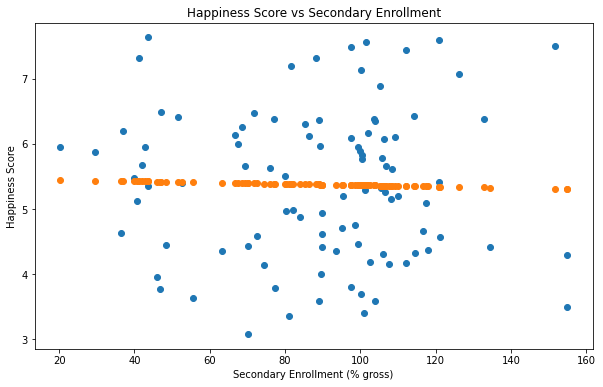

score = -0.00*Secondary Enrollment + 5.47


In [695]:
# plot score vs enrollment
# increase size of plt
df_ = df.dropna(subset=["Secondary_Enrol"])

plt.figure(figsize=(10, 6))
plt.scatter(df_["Secondary_Enrol"],df_["Score"])

reg_sec = LinearRegression().fit(df_["Secondary_Enrol"].values.reshape(-1,1),df_["Score"])
y_pred = reg_sec.predict(df_["Secondary_Enrol"].values.reshape(-1,1))

plt.scatter(df_["Secondary_Enrol"],y_pred)

plt.title("Happiness Score vs Secondary Enrollment")
plt.xlabel("Secondary Enrollment (% gross)")
plt.ylabel("Happiness Score")
plt.show()

# print formated y = mx + b
print("score = {0:.2f}*Secondary Enrollment + {1:.2f}".format(reg_sec.coef_[0],reg_sec.intercept_))

Looking at the above we can see that there is not much relationship between Happiness score and secondary enrollment. 

### **Health Expenditure vs Happiness Score**

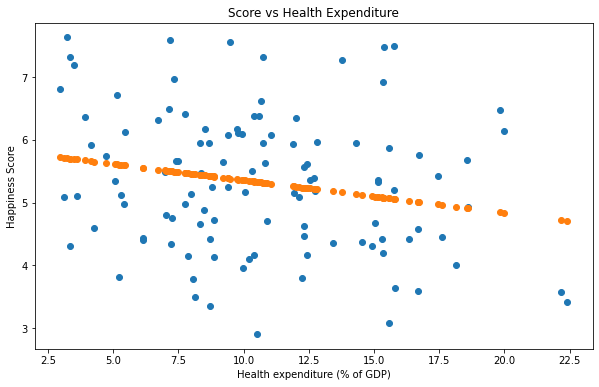

score = -0.05*Health Expenditure + 5.87


In [696]:
# plot score vs health expenditure
# increase size of plt
plt.figure(figsize=(10, 6))
df_ = df.dropna(subset=["health_expenditure"])

plt.scatter(df_["health_expenditure"],df_["Score"])
plt.title("Score vs Health Expenditure")
plt.xlabel("Health expenditure (% of GDP)")
plt.ylabel("Happiness Score")

# create a linear regression model
x = [ [i] for i in df_["health_expenditure"]]
y = df_["Score"]
reg_hlt = LinearRegression().fit(x, y)
y_pred = reg_hlt.predict(x)
plt.scatter(x,y_pred)

plt.show()

# print formated y = mx + b
print("score = {0:.2f}*Health Expenditure + {1:.2f}".format(reg_hlt.coef_[0],reg_hlt.intercept_))

This is a bit better but the fit is almost a horizontal line. This means it will have a big residual, therefore, not a good predictor. 

### **Public spending on education, total (% of GDP) vs Happiness Score**

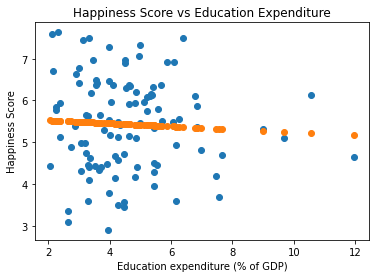

Score = -0.04*Education Expenditure + 5.60


In [697]:
df_ = df.dropna(subset=["spend_Edu_total"])
plt.scatter(df_["spend_Edu_total"],df_["Score"])
plt.title("Happiness Score vs Education Expenditure")
plt.xlabel("Education expenditure (% of GDP)")
plt.ylabel("Happiness Score")
x = [[i] for i in df_["spend_Edu_total"]]
y = df_["Score"]
reg_edu = LinearRegression().fit(x, y)
y_pred = reg_edu.predict(x)
plt.scatter(x,y_pred)
plt.show()

# print formated y = mx + b
print("Score = {0:.2f}*Education Expenditure + {1:.2f}".format(reg_edu.coef_[0],reg_edu.intercept_))


Looking at the above three prediction, we can see that the three features picked from the world bank dataset are not a good predictor of happiness score. This claims is also supported by the tables below. The R-squared value for each is very low. This means much of the variation in score is not explain by the features.

In [698]:
res = smf.ols(formula="Score ~ Secondary_Enrol", data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.06069
Date:                Sun, 15 May 2022   Prob (F-statistic):              0.806
Time:                        22:25:36   Log-Likelihood:                -150.86
No. Observations:                  97   AIC:                             305.7
Df Residuals:                      95   BIC:                             310.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.4677      0.386     14.163      0.000       4.701       6.234
Secondary_Enrol    -0.0010      0.004     -0.246      0.806      -0.009       0.007
==============================================================================
Omnibus:                        5.752   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                2.785
Skew:                           0.118   Prob(JB):                        0.248
Kurtosis:                       2.204   Cond. No.                         304.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [699]:
res = smf.ols(formula="Score ~ spend_Edu_total", data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3224
Date:                Sun, 15 May 2022   Prob (F-statistic):              0.571
Time:                        22:25:36   Log-Likelihood:                -160.50
No. Observations:                 105   AIC:                             325.0
Df Residuals:                     103   BIC:                             330.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.5980      0.311     18.001      0.000       4.981       6.215
spend_Edu_total    -0.0360      0.063     -0.568      0.571      -0.162       0.090
==============================================================================
Omnibus:                        3.997   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                2.302
Skew:                          -0.104   Prob(JB):                        0.316
Kurtosis:                       2.305   Cond. No.                         14.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [700]:
res = smf.ols(formula="Score ~ health_expenditure", data=df).fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     5.057
Date:                Sun, 15 May 2022   Prob (F-statistic):             0.0265
Time:                        22:25:36   Log-Likelihood:                -165.63
No. Observations:                 111   AIC:                             335.3
Df Residuals:                     109   BIC:                             340.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.8746      0.266     22.061      0.000       5.347       6.402
health_expenditure    -0.0518      0.023     -2.249      0.027      -0.098      -0.006
==============================================================================
Omnibus:                        2.403   Durbin-Watson:                   0.111
Prob(Omnibus):                  0.301   Jarque-Bera (JB):                1.901
Skew:                           0.168   Prob(JB):                        0.386
Kurtosis:                       2.454   Cond. No.                         30.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Conclusion

Summary:

Happiness score = -0.00 * Secondary Enrollment + 5.47  | P-value = 0.806 | R^2 = 0.001<br>
Happiness score = -0.05 * Health Expenditure + 5.87    | P-value = 0.027 | R^2 = 0.044  <br>
Happiness score = -0.04 * Education Expenditure + 5.60 | P-value = 0.571 | R^2 = 0.003 <br>

This P-values are only for the slopes as the intercept does not tell us much. 

Looking at the above statistics, we fail to reject the null hypothesis of no relationship since the P-values are high. All of the P-values are significantly different from zero. Additionally, the R^2 square is very small, almost close to zero. This means there is almost no relationship between the features and Happiness Score. 